In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt

from scipy import ndimage
from skimage.feature import peak_local_max
from omegaconf import OmegaConf

from src.annotation.preprocess import *
from src.utils.watershed_utils import get_markers, find_contours

In [2]:
def show_image(im: np.array) -> None:
    plt.imshow(im, cmap='gray')
    plt.axis('off')

In [3]:
img = '../data/covdor/192.168.1.11_2024-12-07T16:42:23.png'
img = cv2.imread(img, 0)
cfg = OmegaConf.load('../configs/watershed/watershed.yaml')
cfg = cfg.preprocess

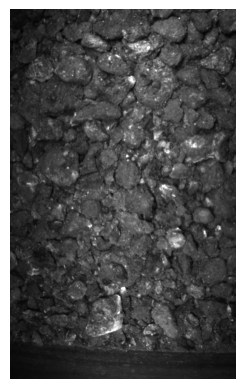

In [4]:
show_image(img)

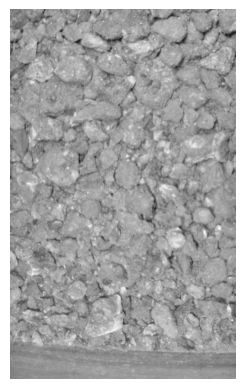

In [5]:
ssr_img = single_scale_retinex(
    img,
    cfg.single_scale_retinex.sigma,
).astype('float32')
show_image(ssr_img)

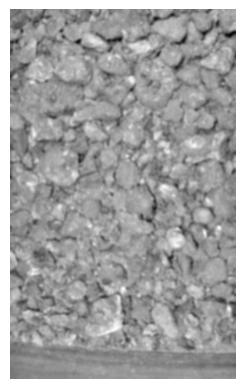

In [6]:
bf = bilateral_filtering(
    ssr_img,
    cfg.bilateral_filtering.diameter,
    cfg.bilateral_filtering.sigma_color,
    cfg.bilateral_filtering.sigma_space,
)
show_image(bf)

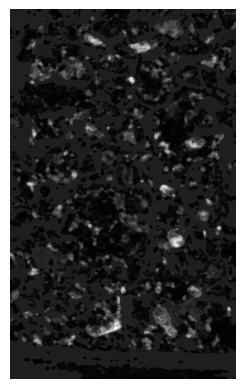

In [7]:
morphed = morphological_transform(
    bf,
    cfg.morphological_transform.kernel_size,
)
show_image(morphed)

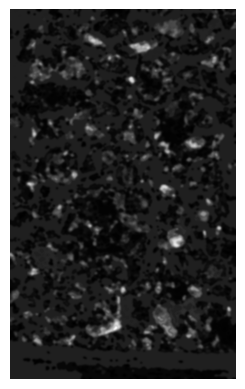

In [8]:
morphed = cv2.GaussianBlur(
    morphed,
    cfg.gaussian_blur.kernel_size,
    cfg.gaussian_blur.sigma_x,
)

m = minmax(
    morphed.ravel(),
    cfg.minmax.span
).astype('uint8')

i = m.reshape(img.shape)
show_image(i)

(array([2.86000e+02, 9.73000e+02, 5.19500e+03, 1.05970e+04, 8.58300e+03,
        7.62300e+03, 7.97600e+03, 1.52760e+04, 1.36400e+04, 1.27630e+04,
        1.11510e+04, 1.03400e+04, 9.59900e+03, 9.92500e+03, 9.97200e+03,
        9.56900e+03, 8.35100e+03, 7.83900e+03, 7.38800e+03, 6.96700e+03,
        7.03300e+03, 6.87000e+03, 6.49600e+03, 6.48000e+03, 6.64500e+03,
        6.68600e+03, 7.53800e+03, 7.66200e+03, 8.70300e+03, 9.78400e+03,
        1.58000e+04, 1.03928e+05, 1.32420e+04, 1.45150e+04, 5.40700e+03,
        6.87300e+03, 3.89400e+03, 3.51000e+03, 3.56500e+03, 3.20900e+03,
        2.84500e+03, 2.42700e+03, 2.34500e+03, 2.23100e+03, 2.32300e+03,
        2.26200e+03, 2.28800e+03, 2.19200e+03, 1.88200e+03, 1.76300e+03,
        1.61400e+03, 1.63500e+03, 1.53600e+03, 1.38800e+03, 1.31100e+03,
        1.20600e+03, 1.21000e+03, 1.14100e+03, 1.17800e+03, 1.06900e+03,
        1.05400e+03, 1.04500e+03, 9.91000e+02, 9.79000e+02, 9.19000e+02,
        9.60000e+02, 9.78000e+02, 9.70000e+02, 9.53

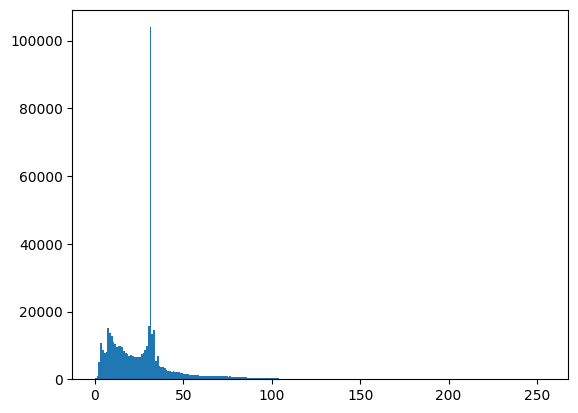

In [9]:
plt.hist(m, bins=255)

In [10]:
m2 = minmax(
    ssr_img.ravel(),
    cfg.minmax.span
).astype('uint8').reshape(img.shape)

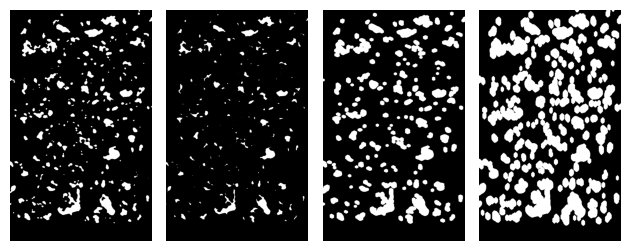

In [15]:
mkr = get_markers('all', i, 50)


emkr = cv2.erode(mkr,
                   cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)),
                   iterations=3)

bmkr = cv2.dilate(emkr,
                   cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)),
                   iterations=3)

bmkrt = cv2.dilate(mkr, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 5)), iterations=5)

fig, ax = plt.subplots(1, 4)

ax[0].imshow(mkr, cmap="gray")
ax[0].set_axis_off()
ax[1].imshow(emkr, cmap="gray")
ax[1].set_axis_off()
ax[2].imshow(bmkr, cmap="gray")
ax[2].set_axis_off()
ax[3].imshow(bmkrt, cmap="gray")
ax[3].set_axis_off()
plt.tight_layout()

In [27]:
distance_map = ndimage.distance_transform_edt(bmkrt)
local_max = peak_local_max(distance_map, min_distance=20, labels=bmkrt)
peak_mask = np.zeros(distance_map.shape, dtype=bool)
peak_mask[tuple(local_max.T)] = True
peak_markers = ndimage.label(peak_mask)[0]

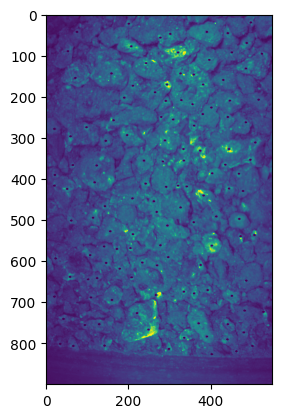

In [28]:
mask = peak_mask.astype(np.uint8) * 255

kernel_size = 7 
structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
big_mask = cv2.dilate(mask, structuring_element, iterations=1)
big_mask2 = cv2.dilate(big_mask, kernel=(3,3), iterations=3)
res = np.where(big_mask == 255, 0, img)

plt.imshow(res)

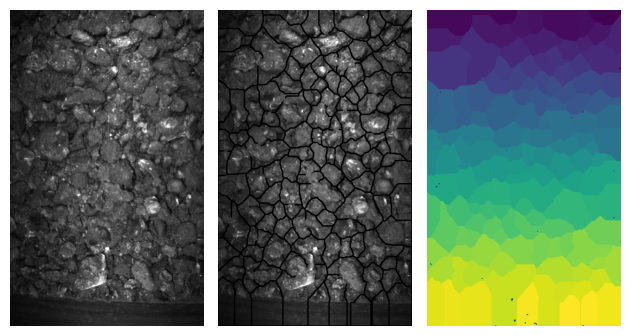

In [29]:
from skimage.segmentation import watershed
labels = watershed(-distance_map, peak_markers, mask=i)
black = find_contours(img, labels, bmkrt)
res = np.where(black == 0, 0, img)

fig, ax = plt.subplots(1, 3)

ax[0].imshow(img, cmap="gray")
ax[0].set_axis_off()
ax[1].imshow(res, cmap="gray")
ax[1].set_axis_off()
ax[2].imshow(labels)
ax[2].set_axis_off()
plt.tight_layout()